In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

salariesDC = pd.read_csv("ds_salaries.csv")
np.random.seed(0)

In [135]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

### Data Sience Salaries ###

As we see above, I've already added the dataset. 

Hi, I'm very interested in being a data sience engineer. But before i want to take this path i really want to know how much this job gets payed. That is why I'm working with this dataset. Now i can practice my skills and find out how much I might earn. :)

### Cleaning ###

I start by cleaning the dataset by making smaller categories for a few columns. I was given the job titles function and had the task to do the same with the countries to categorize them by continent.

# minimalizing values in the job_title column

In [136]:
def segment_job_title(job_title):
    data_scientist_titles = ['Principal Data Scientist', 'Data Scientist','Applied Scientist', 'Research Scientist', 'Applied Data Scientist', 'Lead Data Scientist', 'Staff Data Scientist', 'Principal Data Analyst','Principal Data Engineer']
    machine_learning_titles = ['ML Engineer', 'Machine Learning Engineer','Applied Machine Learning Engineer', 'Machine Learning Researcher','Machine Learning Scientist', 'Autonomous Vehicle Technician', 'AppliedMachine Learning Scientist', 'Principal Machine Learning Engineer','Machine Learning Developer', 'Lead Machine Learning Engineer', 'Machine Learning Manager']
    data_analyst_titles = ['Data Analyst', 'Data Quality Analyst','Compliance Data Analyst', 'Business Data Analyst', 'Staff Data Analyst','Lead Data Analyst', 'BI Data Analyst', 'Marketing Data Analyst', 'Finance Data Analyst']
    data_engineer_titles = ['Data Modeler', 'Data Engineer', 'ETL Engineer', 'Data DevOps Engineer', 'Big Data Engineer', 'Data Infrastructure Engineer', 'Software Data Engineer', 'Cloud Database Engineer', 'Cloud Data Engineer', 'Cloud Data Architect', 'Lead Data Engineer', 'Principal Data Engineer']
    bi_analytics_titles = ['Data Analytics Manager', 'Business Intelligence Engineer', 'Analytics Engineer', 'BI Data Engineer','Director of Data Science', 'BI Developer', 'Insight Analyst', 'Data Analytics Specialist', 'Data Analytics Lead', 'Power BI Developer', 'Cloud Data Architect']
    other_titles = ['Data Strategist', 'Computer Vision Engineer', 'AI Developer', 'Head of Data']
    if job_title in data_scientist_titles:
        return 'Data Scientist'
    elif job_title in machine_learning_titles:
        return 'Machine Learning Engineer'
    elif job_title in data_analyst_titles:
        return 'Data Analyst'
    elif job_title in data_engineer_titles:
        return 'Data Engineer'
    elif job_title in bi_analytics_titles:
        return 'Business Intelligence and Analytics'
    elif job_title in other_titles:
        return 'Other'
    else:
        return 'Uncategorized'


***
Here we replace the values and just to be sure we also check if it actually worked.

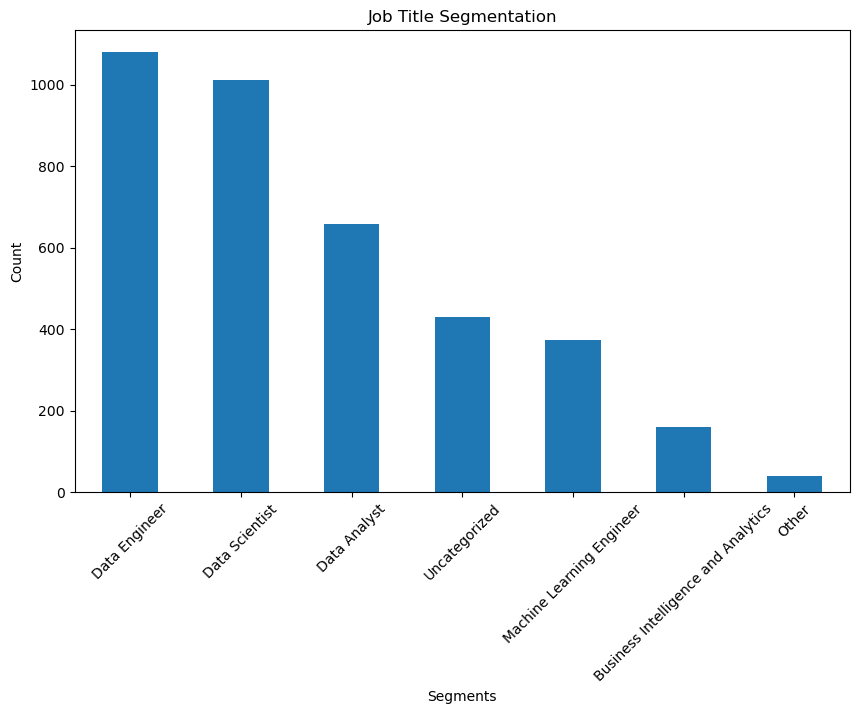

In [137]:
segmented_titles = salariesDC['job_title'].apply(segment_job_title)
segment_counts = segmented_titles.value_counts()

plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar')
plt.title('Job Title Segmentation')
plt.xlabel('Segments')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [138]:
salariesDC['job_title'].sample(20)

953                          Data Engineer
2415                          Data Analyst
3586                         Data Engineer
2969                        Data Scientist
3023                          Data Analyst
1013             Machine Learning Engineer
2666                         Data Engineer
1093                         Data Engineer
2350                          Data Analyst
1791                    Research Scientist
1129             Machine Learning Engineer
1266                        Data Architect
3728                        Data Scientist
1271             Machine Learning Engineer
45                           Data Engineer
1326                         Data Engineer
2976                  Data Science Manager
936                           Data Analyst
3456    Applied Machine Learning Scientist
1021                         Data Engineer
Name: job_title, dtype: object

### That looks good. Now lets do the same with the countries.

In [139]:
location = salariesDC['company_location'].unique()

location.sort()
location

array(['AE', 'AL', 'AM', 'AR', 'AS', 'AT', 'AU', 'BA', 'BE', 'BO', 'BR',
       'BS', 'CA', 'CF', 'CH', 'CL', 'CN', 'CO', 'CR', 'CZ', 'DE', 'DK',
       'DZ', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GH', 'GR', 'HK', 'HN',
       'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IT', 'JP', 'KE',
       'LT', 'LU', 'LV', 'MA', 'MD', 'MK', 'MT', 'MX', 'MY', 'NG', 'NL',
       'NZ', 'PH', 'PK', 'PL', 'PR', 'PT', 'RO', 'RU', 'SE', 'SG', 'SI',
       'SK', 'TH', 'TR', 'UA', 'US', 'VN'], dtype=object)

In [140]:
salariesDC.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [141]:
def add_continent_column(df):
    continent_mapping = {
        'AE': 'Asia',
        'AL': 'Europe',
        'AM': 'Asia',
        'AR': 'South America',
        'AS': 'Oceania',
        'AT': 'Europe',
        'AU': 'Oceania',
        'BA': 'Europe',
        'BE': 'Europe',
        'BO': 'South America',
        'BR': 'South America',
        'BS': 'North America',
        'CA': 'North America',
        'CF': 'Africa',
        'CH': 'Europe',
        'CL': 'South America',
        'CN': 'Asia',
        'CO': 'South America',
        'CR': 'North America',
        'CZ': 'Europe',
        'DE': 'Europe',
        'DK': 'Europe',
        'DZ': 'Africa',
        'EE': 'Europe',
        'EG': 'Africa',
        'ES': 'Europe',
        'FI': 'Europe',
        'FR': 'Europe',
        'GB': 'Europe',
        'GH': 'Africa',
        'GR': 'Europe',
        'HK': 'Asia',
        'HN': 'North America',
        'HR': 'Europe',
        'HU': 'Europe',
        'ID': 'Asia',
        'IE': 'Europe',
        'IL': 'Asia',
        'IN': 'Asia',
        'IQ': 'Asia',
        'IR': 'Asia',
        'IT': 'Europe',
        'JP': 'Asia',
        'KE': 'Africa',
        'LT': 'Europe',
        'LU': 'Europe',
        'LV': 'Europe',
        'MA': 'Africa',
        'MD': 'Europe',
        'MK': 'Europe',
        'MT': 'Europe',
        'MX': 'North America',
        'MY': 'Asia',
        'NG': 'Africa',
        'NL': 'Europe',
        'NZ': 'Oceania',
        'PH': 'Asia',
        'PK': 'Asia',
        'PL': 'Europe',
        'PR': 'North America',
        'PT': 'Europe',
        'RO': 'Europe',
        'RU': 'Europe',
        'SE': 'Europe',
        'SG': 'Asia',
        'SI': 'Europe',
        'SK': 'Europe',
        'TH': 'Asia',
        'TR': 'Asia',
        'UA': 'Europe',
        'US': 'North America',
        'VN': 'Asia'
    }

    df['Country Code'] = df['company_location'].str.strip()
    df['Country Code'] = df['Country Code'].apply(lambda x: x.split(',')[0])
    df['Continent'] = df['Country Code'].map(continent_mapping)
    df.drop('company_location', axis=1, inplace=True)
    return df

# Assuming 'salariesDC' is your dataset
salariesDC = add_continent_column(salariesDC)
salariesDC.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_size,Country Code,Continent
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,L,ES,Europe
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,S,US,North America
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,S,US,North America
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,M,CA,North America
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,M,CA,North America


array([[<AxesSubplot: title={'center': 'salary_in_usd'}>]], dtype=object)

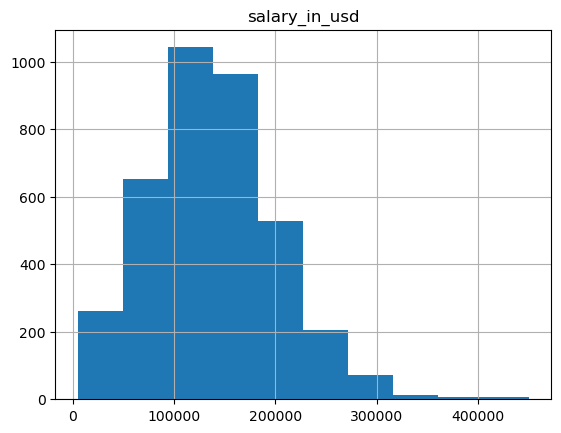

In [142]:
salariesDC.hist(column=['salary_in_usd'])

In [143]:
a = salariesDC.isnull().sum()
a

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_size          0
Country Code          0
Continent             0
dtype: int64

In [144]:
print(salariesDC['Continent'].sample(20))

2880    North America
229     North America
63      North America
979     North America
254     North America
2709    North America
2924    North America
2535    North America
2866    North America
2237           Europe
1865    North America
3493    North America
110     North America
2195    North America
1126    North America
773     North America
200     North America
2646    North America
874     North America
1747    North America
Name: Continent, dtype: object


In [145]:
salariesDC.shape

(3755, 12)

In [146]:
salariesDC.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_size', 'Country Code', 'Continent'],
      dtype='object')

In [147]:
salariesDC.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_size,Country Code,Continent
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,L,ES,Europe
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,S,US,North America
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,S,US,North America
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,M,CA,North America
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,M,CA,North America


### First challenge: changing the country codes ###

As we can see in the output above there are alot of country codes. To make these into smaller categories I asked ChatGPT to organise these country codes into continents and then used the same function as above to categorize them into continents.

Now we have a few continents to work with. Let's check if this worked.

In [148]:
salariesDC.drop('salary_currency', axis=1, inplace=True)
salariesDC.drop(['Country Code'], axis=1, inplace=True)
salariesDC.head()

,work_year,experience_level,employment_type,job_title,salary,salary_in_usd,employee_residence,remote_ratio,company_size,Continent
0,2023,SE,FT,Principal Data Scientist,80000,85847,ES,100,L,Europe
1,2023,MI,CT,ML Engineer,30000,30000,US,100,S,North America
2,2023,MI,CT,ML Engineer,25500,25500,US,100,S,North America
3,2023,SE,FT,Data Scientist,175000,175000,CA,100,M,North America
4,2023,SE,FT,Data Scientist,120000,120000,CA,100,M,North America


Yep that looks good. Just in case we'll also check if there are any missing values that need to be cleaned.

In [149]:
salariesDC.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_size          0
Continent             0
dtype: int64

make sure you only use salar in usd, after this column is made, then remove the other salary related columns. 

As we can see the dataset is clean and there is no further work to do on this part.

Let's look at a small visualisation of what were working with:

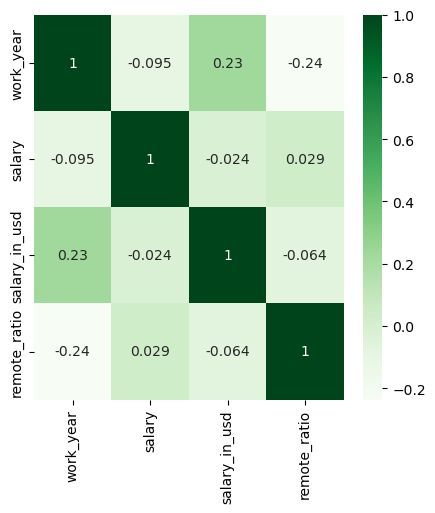

In [150]:
plt.figure(figsize=(5,5))
sns.heatmap(salariesDC.corr(),annot=True,cmap='Greens')
plt.show()

## time to do the grid search with cross validation ##

First we split our dataset into training and testing.

In [151]:
X = salariesDC.drop('salary_in_usd', axis=1)  
y = salariesDC['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train  # Print the training features

,work_year,experience_level,employment_type,job_title,salary,employee_residence,remote_ratio,company_size,Continent
2238,2022,SE,FT,Data Engineer,35000,ES,0,M,Europe
485,2023,MI,FT,Research Scientist,151800,US,100,M,North America
2177,2022,SE,FT,Data Analyst,100000,US,0,M,North America
3305,2022,SE,FT,Data Engineer,156600,US,100,M,North America
1769,2023,SE,FT,Data Engineer,175000,US,100,M,North America
...,...,...,...,...,...,...,...,...,...
1130,2023,SE,FT,Machine Learning Engineer,150000,US,100,M,North America
1294,2023,SE,FT,Data Analyst,180180,US,0,M,North America
860,2023,EX,FT,Data Engineer,310000,US,100,M,North America
3507,2021,MI,FT,Research Scientist,53000,FR,50,M,Europe


In [152]:
print(X.shape)
print(y.shape)

(3755, 9)
(3755,)


Then we start to do the grid search. This is where i ran into a problem. The grid search gave me an error about the object types so we needed to change those to int64.

In [153]:
#grid_search.fit(X_train, y_train) 

# gives me an error that it cant convert type string to float

print(salariesDC.dtypes)

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_size          object
Continent             object
dtype: object


the grid search expects a numerical input so this is why we are using OneHotEncoder that created binary columns so we can use these in the grid search.

In [154]:
label_encoder = LabelEncoder()
categorical_columns = ['experience_level', 'employment_type', 'job_title', 'Continent', 'company_size','employee_residence']
salariesDC[categorical_columns] = salariesDC[categorical_columns].apply(lambda x: label_encoder.fit_transform(x))

Let's check if what we did is correct.

In [155]:
print(salariesDC.dtypes)

work_year             int64
experience_level      int64
employment_type       int64
job_title             int64
salary                int64
salary_in_usd         int64
employee_residence    int64
remote_ratio          int64
company_size          int64
Continent             int64
dtype: object


In [156]:
salariesDC.head(20)


,work_year,experience_level,employment_type,job_title,salary,salary_in_usd,employee_residence,remote_ratio,company_size,Continent
0,2023,3,2,84,80000,85847,26,100,0,2
1,2023,2,0,66,30000,30000,75,100,2,3
2,2023,2,0,66,25500,25500,75,100,2,3
3,2023,3,2,47,175000,175000,11,100,1,3
4,2023,3,2,47,120000,120000,11,100,1,3
5,2023,3,2,8,222200,222200,75,0,0,3
6,2023,3,2,8,136000,136000,75,0,0,3
7,2023,3,2,47,219000,219000,11,0,1,3
8,2023,3,2,47,141000,141000,11,0,1,3
9,2023,3,2,47,147100,147100,75,0,1,3


In [157]:
salariesDC.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_size          0
Continent             0
dtype: int64

In [158]:
salariesDC.dtypes

work_year             int64
experience_level      int64
employment_type       int64
job_title             int64
salary                int64
salary_in_usd         int64
employee_residence    int64
remote_ratio          int64
company_size          int64
Continent             int64
dtype: object

In [159]:
print(X.shape)
print(y.shape)

(3755, 9)
(3755,)


In [160]:
categorical_columns = ['experience_level', 'employment_type', 'job_title', 'Continent', 'company_size']
onehot_encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_columns]))

X_encoded.columns = onehot_encoder.get_feature_names_out(categorical_columns)
X_encoded = pd.concat([X_encoded, X.select_dtypes(include=['float64'])], axis=1)

In [161]:
print(X_encoded)

      experience_level_EX  experience_level_MI  experience_level_SE  \
0                     0.0                  0.0                  1.0   
1                     0.0                  1.0                  0.0   
2                     0.0                  1.0                  0.0   
3                     0.0                  0.0                  1.0   
4                     0.0                  0.0                  1.0   
...                   ...                  ...                  ...   
3750                  0.0                  0.0                  1.0   
3751                  0.0                  1.0                  0.0   
3752                  0.0                  0.0                  0.0   
3753                  0.0                  0.0                  0.0   
3754                  0.0                  0.0                  1.0   

      employment_type_FL  employment_type_FT  employment_type_PT  \
0                    0.0                 1.0                 0.0   
1          

For the grid search we need to use "Param_grid" which i was very confused about but after some research i found out that it cross validates the variables to find the 
best one and uses those parameters to do the grid search.

Now we do the grid search again and lets see what the outcomes are.

***


***

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid =  {    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10 ,20,21, 22, 23 ,25, 30, 40, 50],
    'min_samples_leaf': [1, 2, 3, 4 , 5 ,],}   
# Create a decision tree classifier
model = DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameter and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


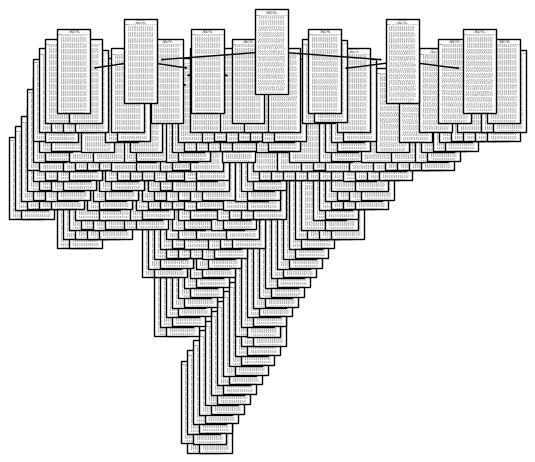

In [163]:
from sklearn.tree import plot_tree

# Access the best estimator from the GridSearchCV object
best_model = grid_search.best_estimator_

plot_tree(best_model)
plt.show()

So, as we can see our best_score is very low. When trying to fix this problem I widened the 

In [164]:
#grid_search.fit(X_encoded, y)

In [165]:
##best_params = grid_search.best_params_
#best_score = grid_search.best_score_

#best_params

### Feature Importance ###

feature importance is needed to show the most relevant features that are needed for the decision-making process. 
So the output will show a score of importance.

In [166]:
model.fit(X_encoded, y)

importance = model.feature_importances_

for feature_name, feature_importance in zip(X.columns, importance):
    print(f"{feature_name}: {feature_importance}")

work_year: 0.01670848630053308
experience_level: 0.042888377666213215
employment_type: 0.023945389565661394
job_title: 0.00184983584529027
salary: 0.02688293966463101
employee_residence: 0.011182471597615215
remote_ratio: 0.014965936327234797
company_size: 0.00246644779372036
Continent: 0.01650188084949687


From high to low these are the top 6 most relevant features.

experience_level
employment_type
work_year
comp_location
sal_cur
comp_size


In [167]:
subset = salariesDC[['experience_level', 'employment_type', 'work_year', 'salary']]

subset

,experience_level,employment_type,work_year,salary
0,3,2,2023,80000
1,2,0,2023,30000
2,2,0,2023,25500
3,3,2,2023,175000
4,3,2,2023,120000
...,...,...,...,...
3750,3,2,2020,412000
3751,2,2,2021,151000
3752,0,2,2020,105000
3753,0,0,2020,100000


In [168]:
categorical_columns = ['experience_level', 'employment_type']
onehot_encoder = OneHotEncoder(drop='first', sparse=False)
X_encodedsub = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_columns]))
X_encodedsub.columns = onehot_encoder.get_feature_names(categorical_columns)
X_encodedsub = pd.concat([X_encoded, X.select_dtypes(include=['float64'])], axis=1)

/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [169]:
X = subset.drop('salary', axis=1)  
y = subset['salary']

Xsub_train, Xsub_test, ysub_train, ysub_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
# Define the parameter grid
param_grid =  {    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10 ,20,21, 22, 23 ,25, 30, 40, 50],
    'min_samples_leaf': [1, 2, 3, 4 , 5 ,],}   
# Create a decision tree classifier
model = DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(Xsub_train, ysub_train)

# Get the best parameter and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [171]:
grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_encodedsub, y)

/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [5, 10, 20, 21, 22, 23, 25, 30,
                                               40, 50]})

In [172]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 30}
0.05832223701731025


## RANDOM SEARCH ##

In [173]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(model, param_grid, cv=5)

random_search.fit(X_encoded, y)

/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [5, 10, 20, 21, 22,
                                                              23, 25, 30, 40,
                                                              50]})

In [174]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print(best_params)
print(best_score)


{'min_samples_split': 30, 'min_samples_leaf': 2, 'criterion': 'gini'}
0.05752330226364847
